In [2]:
import os
from ast import literal_eval
from datetime import datetime
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from phik import phik_matrix
import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(style='white')
sns.set_theme(rc={'axes.facecolor':'#FFEFD5','figure.facecolor':'#FFEFD5'})
sns.set_context('poster',font_scale = .7)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602', '#9B59B6', '#E74C3C']

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

DATA_DIR = Path().resolve().parent / 'data'

In [3]:
def check_df(dataframe, head=5):
    print('SHAPE'.center(70,'-'))
    print(dataframe.shape)
    print('HEAD'.center(70,'-'))
    print(dataframe.head(head))
    print('INFO'.center(70,'-'))
    print(dataframe.info())
    print('NUNIQUE'.center(70,'-'))
    print(dataframe.nunique())
    print('MISSING VALUES'.center(70,'-'))
    print(dataframe.isnull().sum())
    print('DUPLICATED ROWS'.center(70,'-'))
    print(dataframe.duplicated().sum())


def plot_numeric_col(data, column, bins=30, figsize=(16, 8)):
    """
    Создает комплексный график для количественной переменной
    """
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])

    # Гистограмма с KDE
    ax1 = plt.subplot(gs[0, :])
    sns.histplot(data=data, x=column, bins=bins, kde=True,
                color=colors[0], alpha=0.7, ax=ax1)
    ax1.axvline(data[column].mean(), color='red', linestyle='--',
               label=f'Mean: {data[column].mean():.2f}')
    ax1.axvline(data[column].median(), color='green', linestyle='--',
               label=f'Median: {data[column].median():.2f}')
    ax1.set_title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    ax1.set_xlabel(column, fontsize=14)
    ax1.set_ylabel('Frequency', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot
    ax2 = plt.subplot(gs[1, 0])
    sns.boxplot(x=data[column], color=colors[1], ax=ax2)
    ax2.set_title(f'Boxplot of {column}', fontsize=14)
    ax2.set_xlabel(column, fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Violin plot
    ax3 = plt.subplot(gs[1, 1])
    sns.violinplot(x=data[column], color=colors[2], ax=ax3)
    ax3.set_title(f'Violin Plot of {column}', fontsize=14)
    ax3.set_xlabel(column, fontsize=12)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_categorical_col(data, column, top_n=10, figsize=(16, 8)):
    """
    Комплексный график для категориальной переменной
    """
    # Подготовка данных
    value_counts = data[column].value_counts()
    if len(value_counts) > top_n:
        top_categories = value_counts.head(top_n)
        other_count = value_counts[top_n:].sum()
        top_categories['Other'] = other_count
    else:
        top_categories = value_counts

    # Создание subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Столбчатая диаграмма
    bars = ax1.bar(range(len(top_categories)), top_categories.values,
                  color=colors[:len(top_categories)], alpha=0.8)
    ax1.set_title(f'Bar Chart of {column}', fontsize=16, fontweight='bold')
    ax1.set_xlabel(column, fontsize=14)
    ax1.set_ylabel('Count', fontsize=14)
    ax1.set_xticks(range(len(top_categories)))
    ax1.set_xticklabels(top_categories.index, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)

    # Добавление значений на столбцы
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontsize=10)

    # Круговая диаграмма
    wedges, texts, autotexts = ax2.pie(top_categories.values,
                                      labels=top_categories.index,
                                      autopct='%1.1f%%',
                                      colors=colors[:len(top_categories)],
                                      startangle=90)
    ax2.set_title(f'Pie Chart of {column}', fontsize=16, fontweight='bold')

    # Улучшение читаемости
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    plt.tight_layout()
    plt.show()

## Загрузка и предобработка данных

In [4]:
df = pd.read_csv(DATA_DIR / 'Spb_flats_prices.csv')
check_df(df)

--------------------------------SHAPE---------------------------------
(1080, 9)
---------------------------------HEAD---------------------------------
                                   Underground Times  \
0  {'Underground name': ['Балтийская', 'Василеост...   
1  {'Underground name': ['Московская', 'Бухарестс...   
2  {'Underground name': ['Василеостровская', 'Спо...   
3  {'Underground name': ['Улица Дыбенко', 'Проспе...   
4  {'Underground name': ['Девяткино', 'Граждански...   

   Flat Status (1 - handed over, 0 - not handed over) Flat Type  \
0                                                  1     4-комн   
1                                                  1     2-комн   
2                                                  0     3-комн   
3                                                  1     2-комн   
4                                                  1     1-комн   

   Total Area (m^2)  Living Area (m^2)  Kitchen Area (m^2)  Floor  \
0            125.50               75.8 

In [5]:
df.columns = ['metro_info',
             'flat_status',
             'num_of_rooms',
             'total_area_m2',
             'living_area_m2',
             'kitchen_area_m2',
             'floor',
             'year_of_bulding',
             'price']

In [6]:
def nearest_metro_station(json):
    stations_dict = literal_eval(json)

    nearest_station = stations_dict['Underground name'][0]
    time_to_get = stations_dict['Underground time'][0]
    way_to_get_to = stations_dict['Transport type'][0]

    return [nearest_station, time_to_get, way_to_get_to]

In [7]:
df[['metro_station',
    'minutes_to_metro',
    'transfer_type']] = pd.DataFrame(df['metro_info'].apply(lambda x: nearest_metro_station(x)).tolist(),
                                     index=df.index)
df.drop('metro_info', axis=1, inplace=True)

In [8]:
df['num_of_rooms'].unique()

array(['4-комн', '2-комн', '3-комн', '1-комн', '5-комн', 'Студия',
       'Многокомнатны', 'Многокомнатна', 'Апартаменты-студия', '15/4',
       'Квартир', '29/4'], dtype=object)

In [9]:
df['num_of_rooms'] = df['num_of_rooms'].apply(lambda x: 'Неизвестно' if x in ['Многокомнатны',
                                                                          'Многокомнатна',
                                                                          '15/4',
                                                                          'Квартир',
                                                                          '29/4'] else x)

In [10]:
replacements = {
    'Апартаменты-студия': 'Студия',
    '1-комн': '1-комнатная'
}
df['num_of_rooms'] = df['num_of_rooms'].replace('Апартаменты-студия', 'Студия')

In [11]:
df['num_of_rooms'] = df['num_of_rooms'].apply(lambda x: x + 'атная' if x not in ['Студия', 'Неизвестно'] else x)

In [12]:
df['num_of_rooms'].unique()

array(['4-комнатная', '2-комнатная', '3-комнатная', '1-комнатная',
       '5-комнатная', 'Студия', 'Неизвестно'], dtype=object)

In [13]:
df.duplicated().sum()

np.int64(82)

In [14]:
current_year = datetime.now().year
df['house_age'] = (current_year - df['year_of_bulding']).apply(lambda x: x if x > 0 else 0)

In [15]:
df['is_future_building'] = (df['year_of_bulding'] > current_year).astype(int)
df.drop('year_of_bulding', axis=1, inplace=True)

In [16]:
df.head()

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
0,1,4-комнатная,125.50,75.8,22.9,4,24500000,Балтийская,5,car,149,0
1,1,2-комнатная,41.50,26.4,6.0,3,6300000,Московская,6,car,61,0
2,0,3-комнатная,80.39,44.9,10.2,3,30061520,Василеостровская,11,legs,0,0
3,1,2-комнатная,65.10,27.0,19.0,4,11500000,Улица Дыбенко,7,car,42,0
4,1,1-комнатная,38.50,16.6,10.5,10,5599000,Девяткино,6,car,10,0


In [17]:
df['minutes_to_metro'] = df['minutes_to_metro'].replace('откроется', 10).astype(int)

In [18]:
df['transfer_type'] = df['transfer_type'].replace({'car': 'на машине', 'legs': 'пешком'})

In [19]:
check_df(df)

--------------------------------SHAPE---------------------------------
(1080, 12)
---------------------------------HEAD---------------------------------
   flat_status num_of_rooms  total_area_m2  living_area_m2  kitchen_area_m2  \
0            1  4-комнатная         125.50            75.8             22.9   
1            1  2-комнатная          41.50            26.4              6.0   
2            0  3-комнатная          80.39            44.9             10.2   
3            1  2-комнатная          65.10            27.0             19.0   
4            1  1-комнатная          38.50            16.6             10.5   

   floor     price     metro_station  minutes_to_metro transfer_type  \
0      4  24500000        Балтийская                 5     на машине   
1      3   6300000        Московская                 6     на машине   
2      3  30061520  Василеостровская                11        пешком   
3      4  11500000     Улица Дыбенко                 7     на машине   
4     10   5

In [20]:
df.drop_duplicates(inplace=True)

## EDA

In [21]:
df.head()

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
0,1,4-комнатная,125.50,75.8,22.9,4,24500000,Балтийская,5,на машине,149,0
1,1,2-комнатная,41.50,26.4,6.0,3,6300000,Московская,6,на машине,61,0
2,0,3-комнатная,80.39,44.9,10.2,3,30061520,Василеостровская,11,пешком,0,0
3,1,2-комнатная,65.10,27.0,19.0,4,11500000,Улица Дыбенко,7,на машине,42,0
4,1,1-комнатная,38.50,16.6,10.5,10,5599000,Девяткино,6,на машине,10,0


In [22]:
shape_before_eda = df.shape

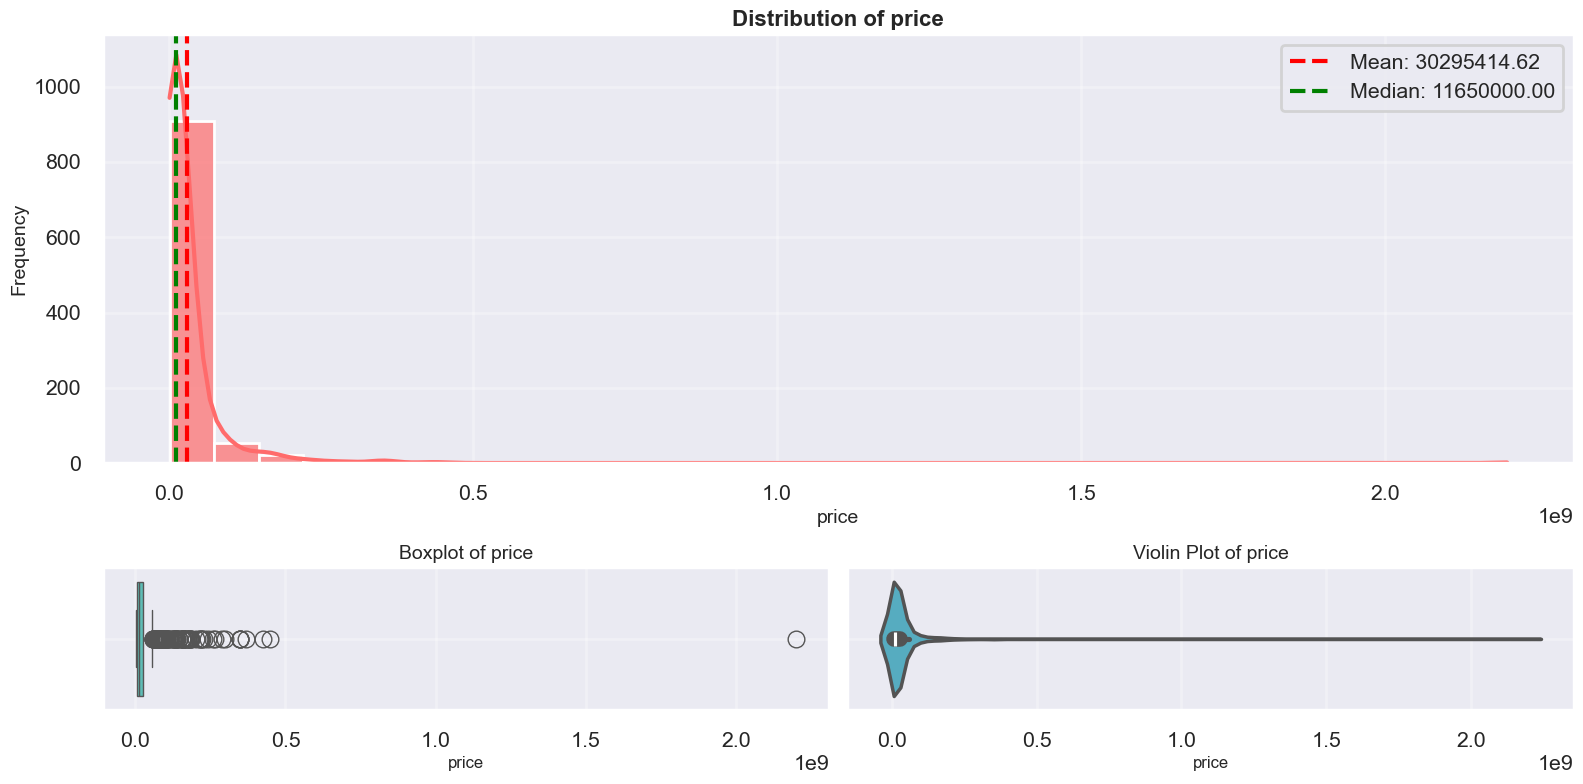

In [23]:
plot_numeric_col(df, 'price')

In [24]:
df = df[df['price'] < 45000000]

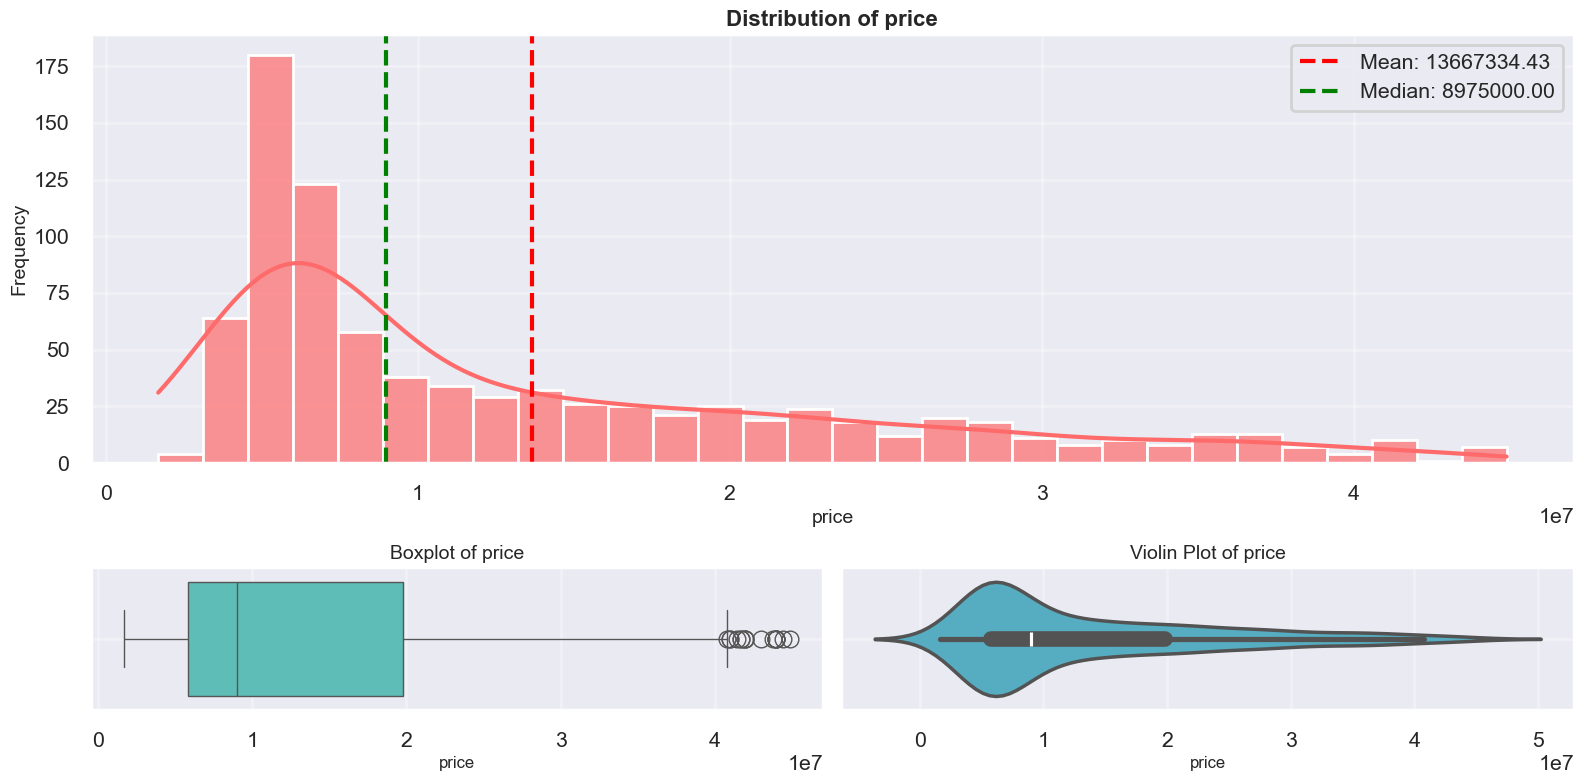

In [25]:
plot_numeric_col(df, 'price')

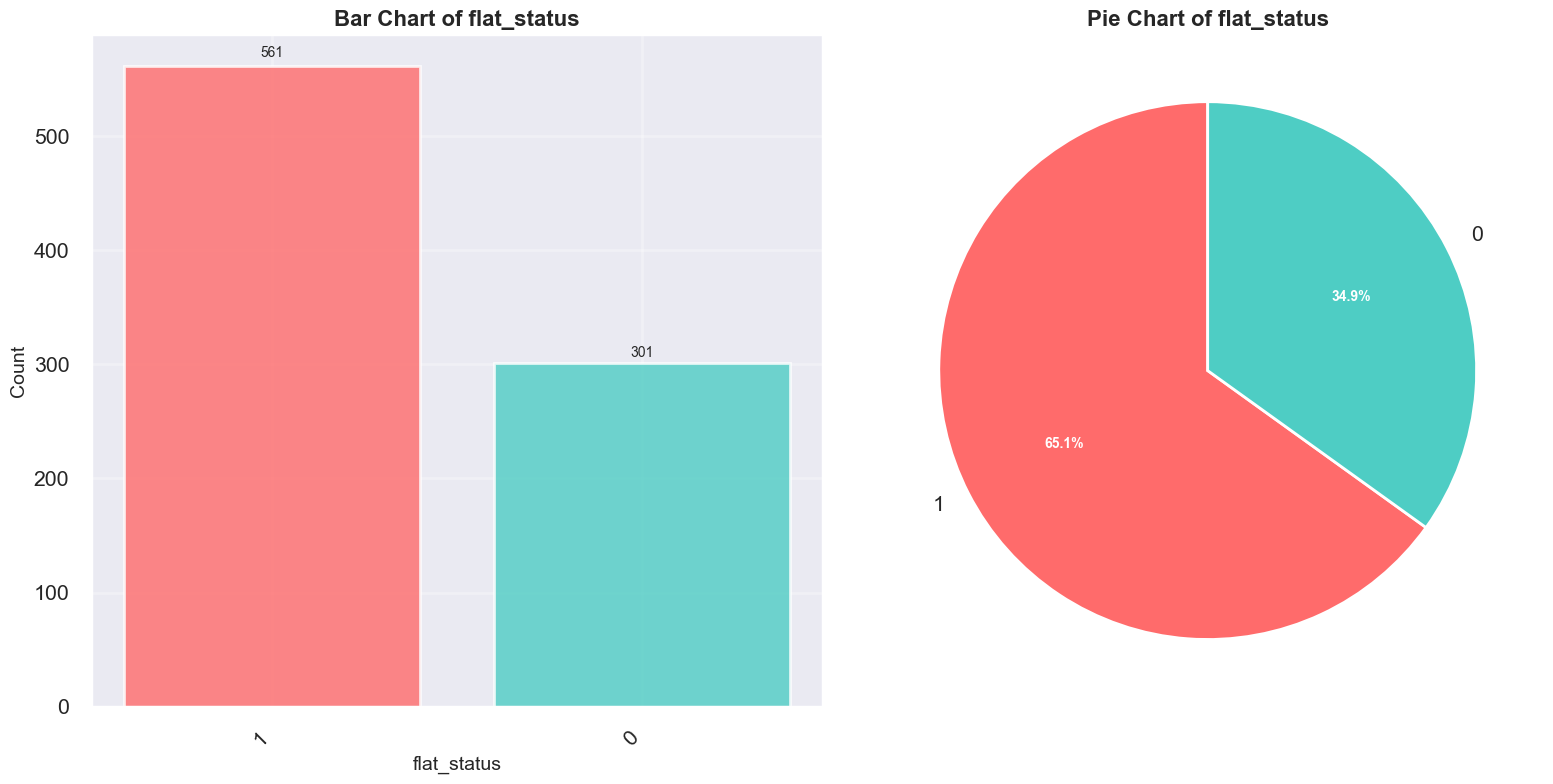

In [26]:
plot_categorical_col(df, 'flat_status')

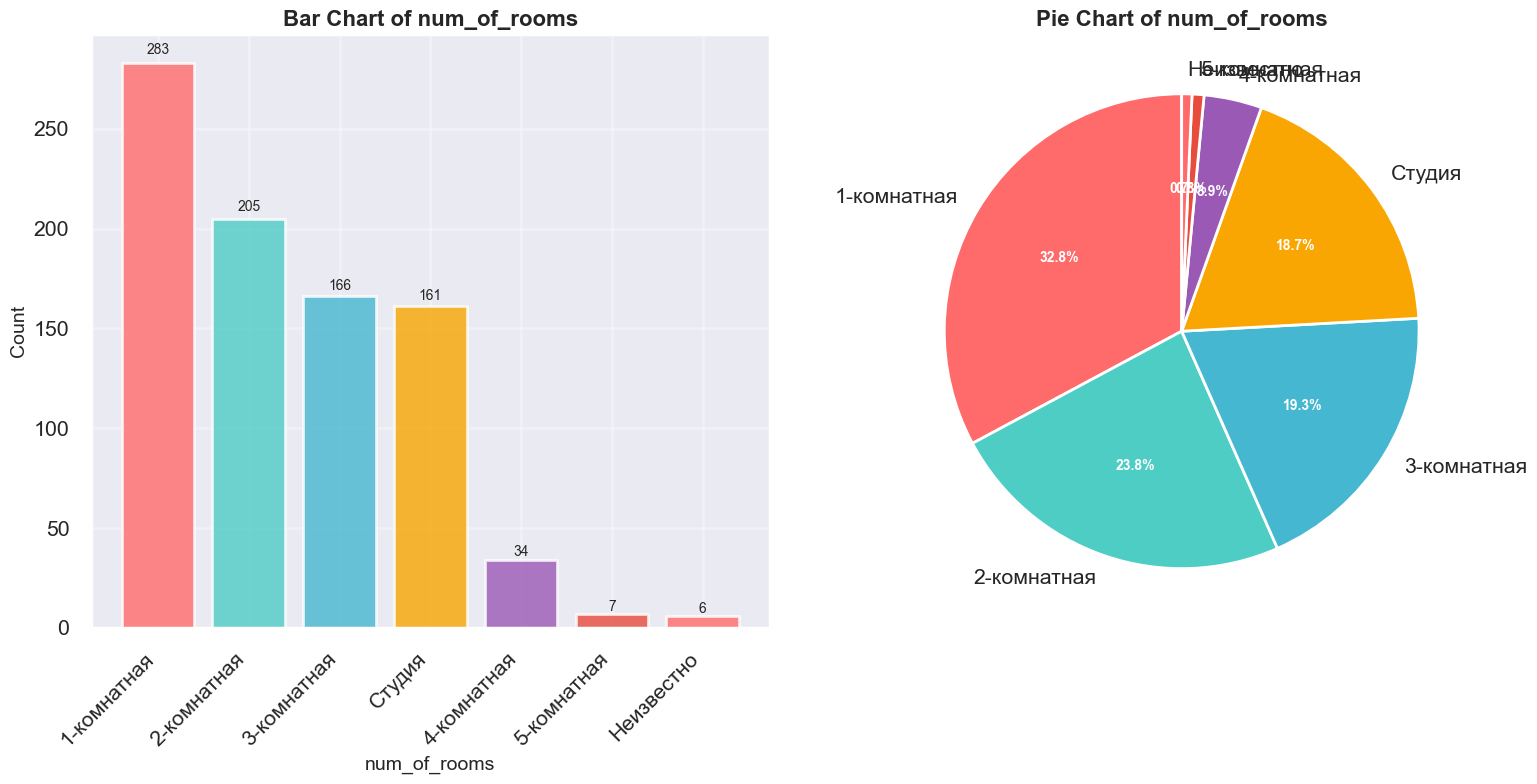

In [27]:
plot_categorical_col(df, 'num_of_rooms')

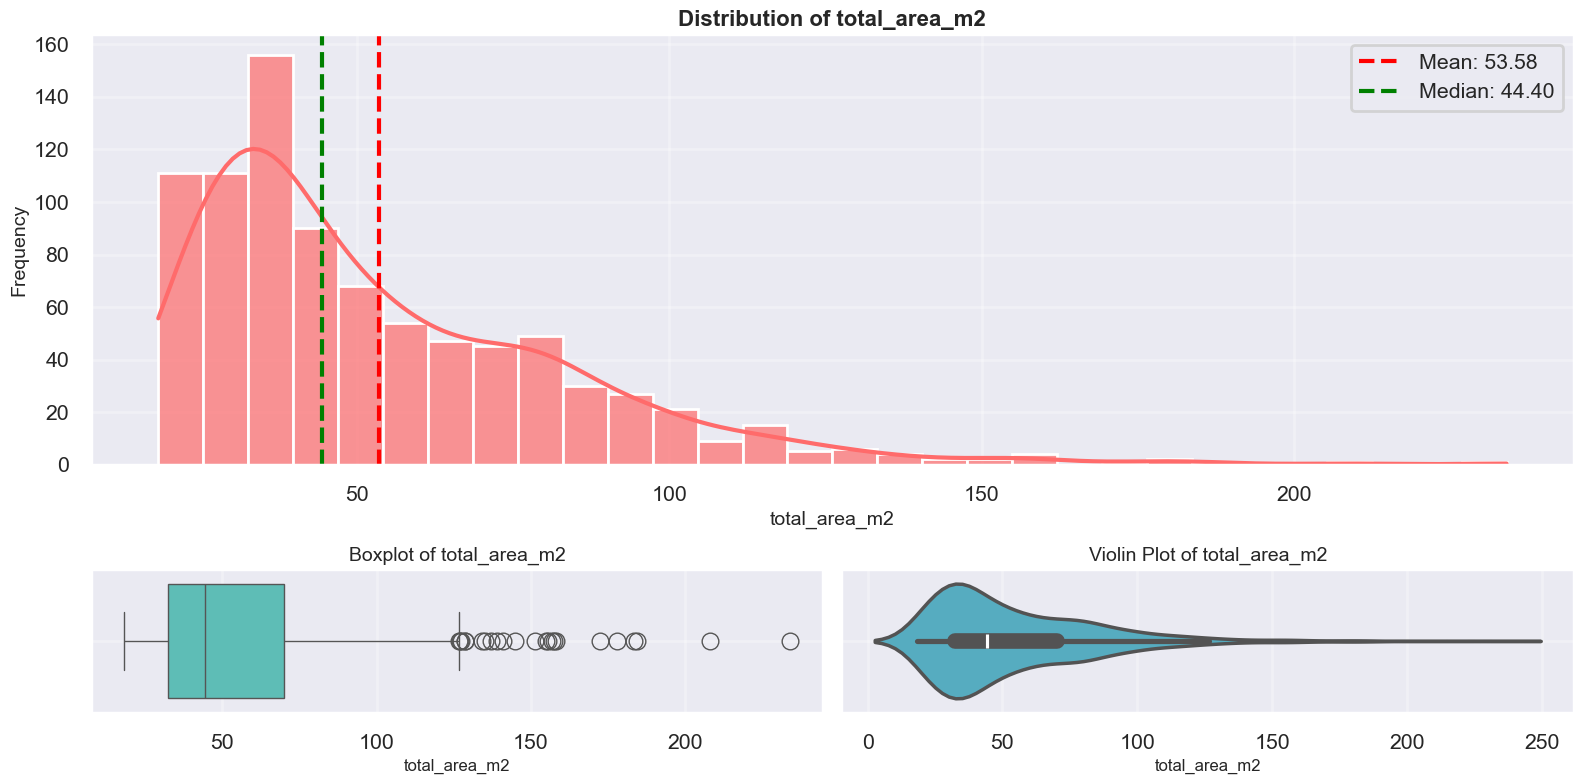

In [28]:
plot_numeric_col(df, 'total_area_m2')

In [29]:
#df = df[df['total_area_m2'] <= 210]

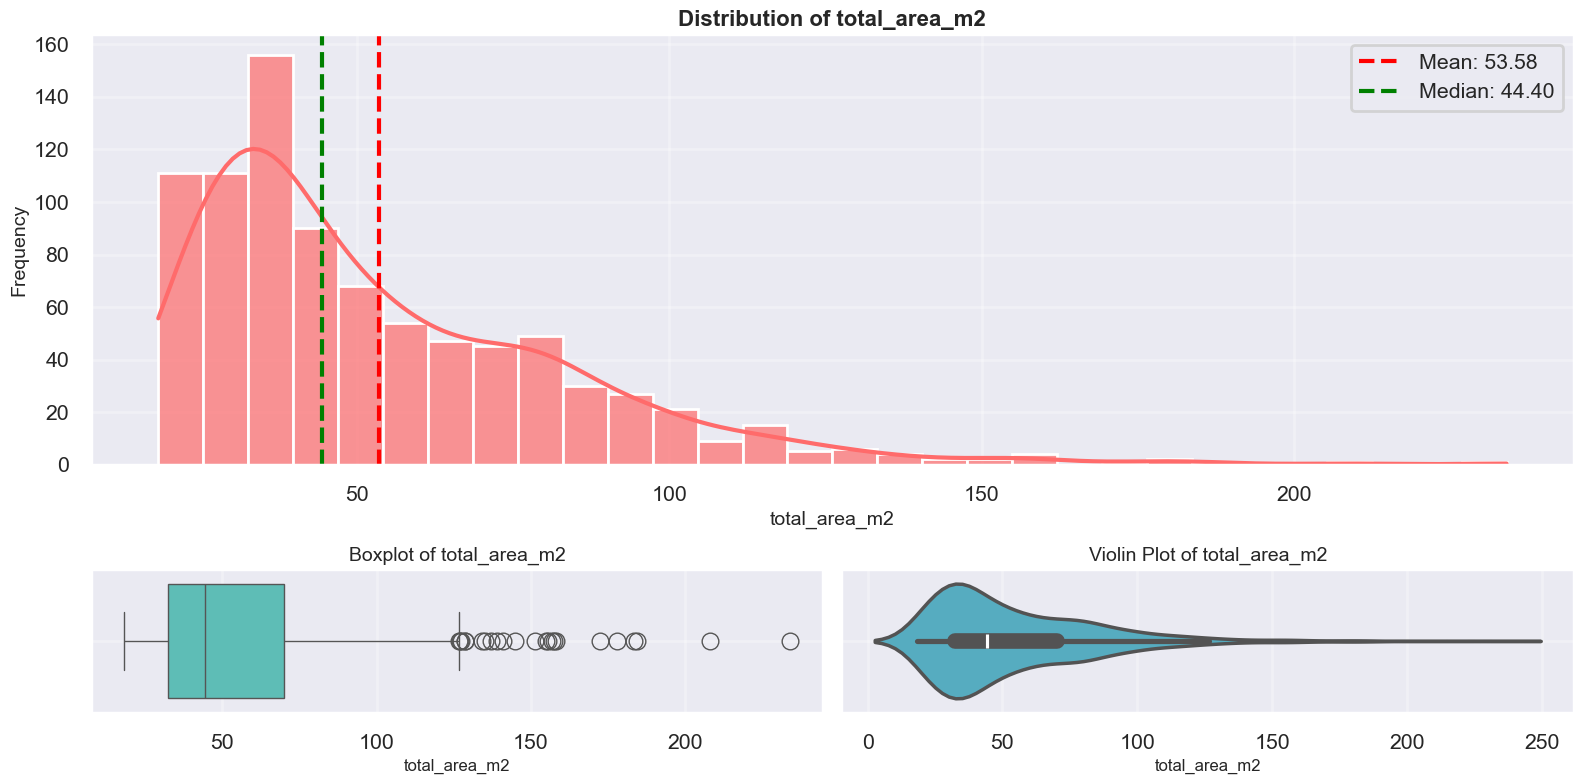

In [30]:
plot_numeric_col(df, 'total_area_m2')

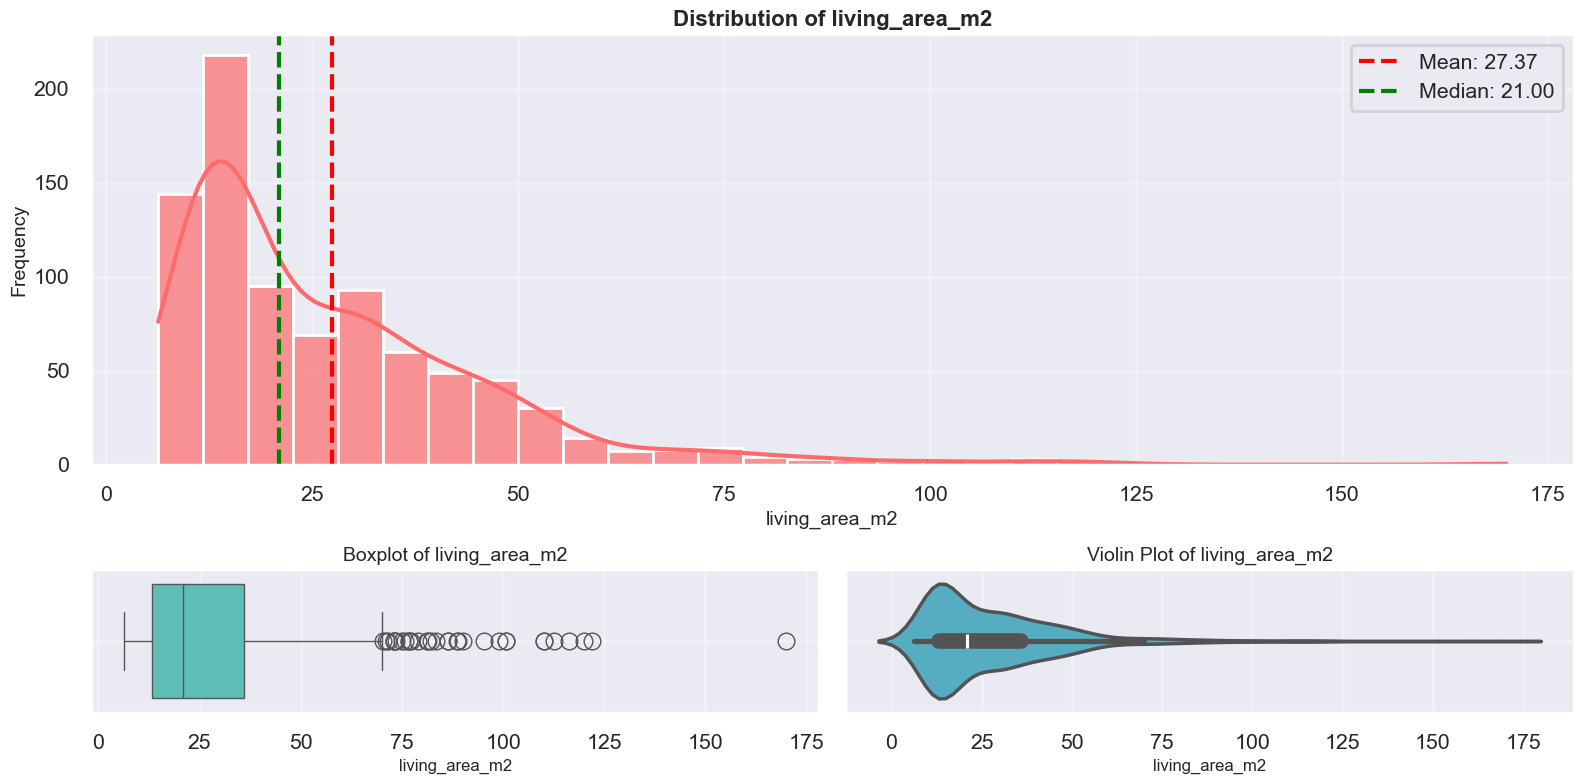

In [31]:
plot_numeric_col(df, 'living_area_m2')

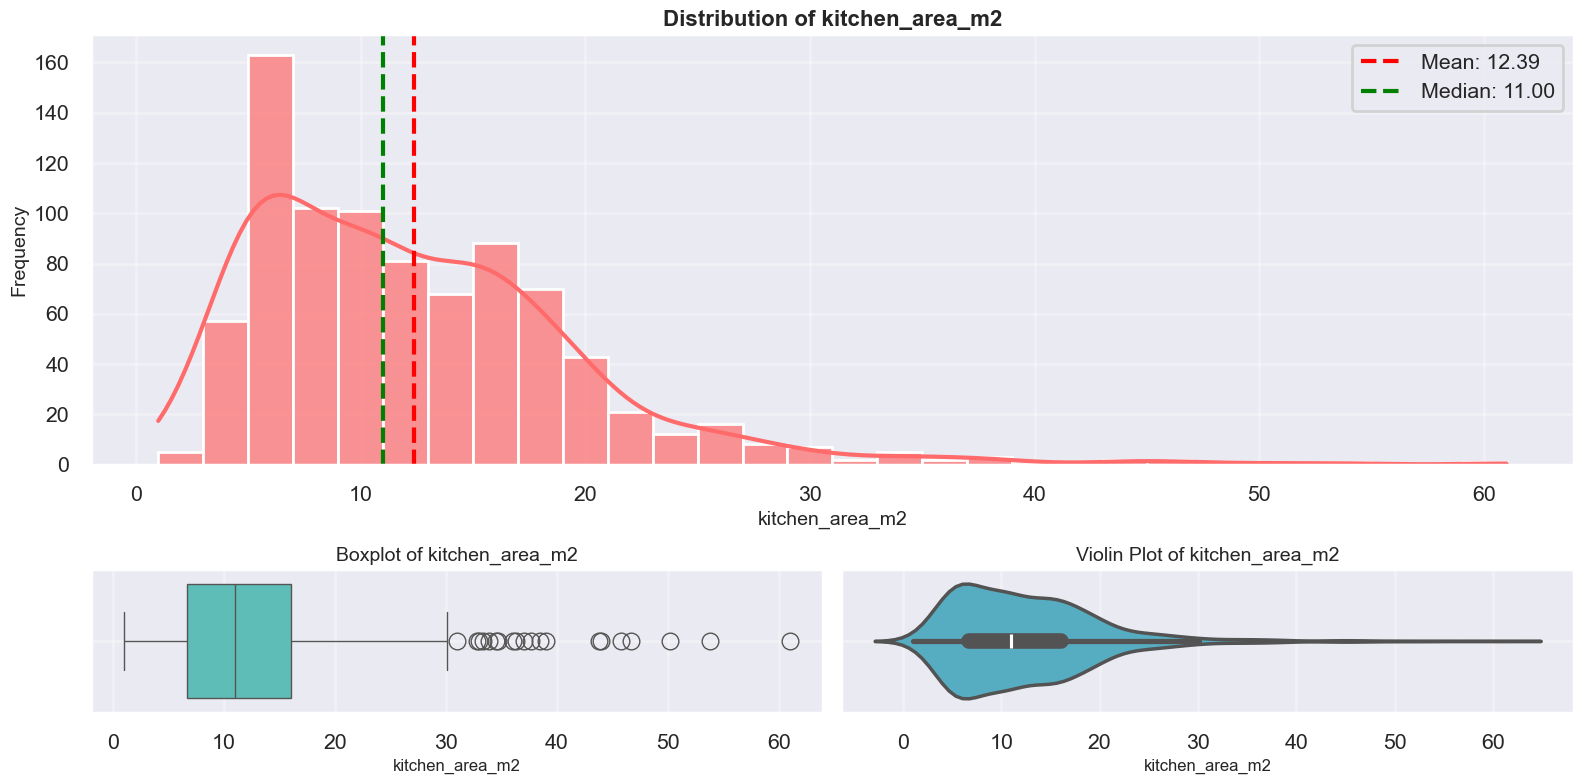

In [32]:
plot_numeric_col(df, 'kitchen_area_m2')

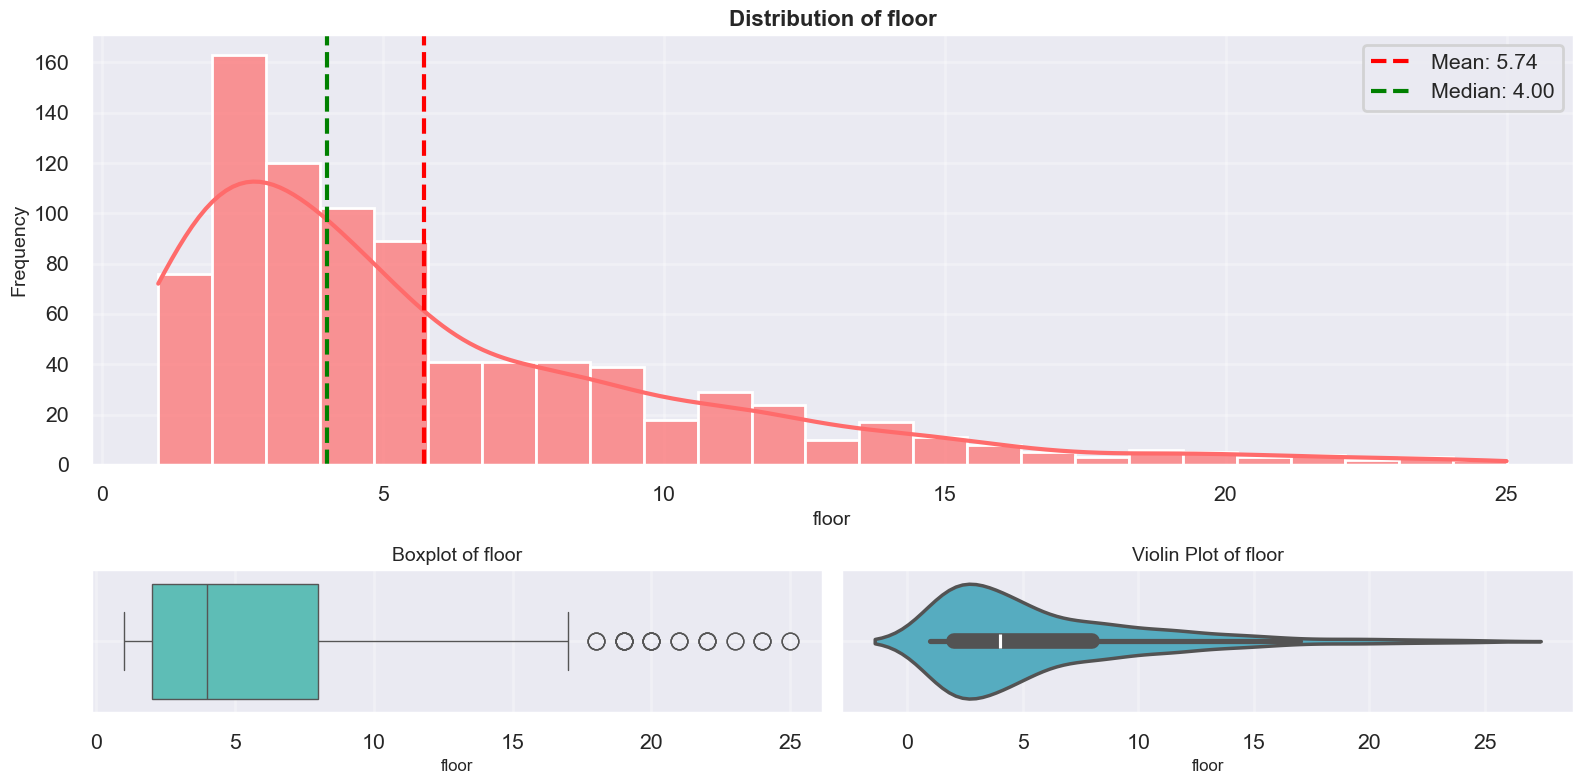

In [33]:
plot_numeric_col(df, 'floor', bins=25)

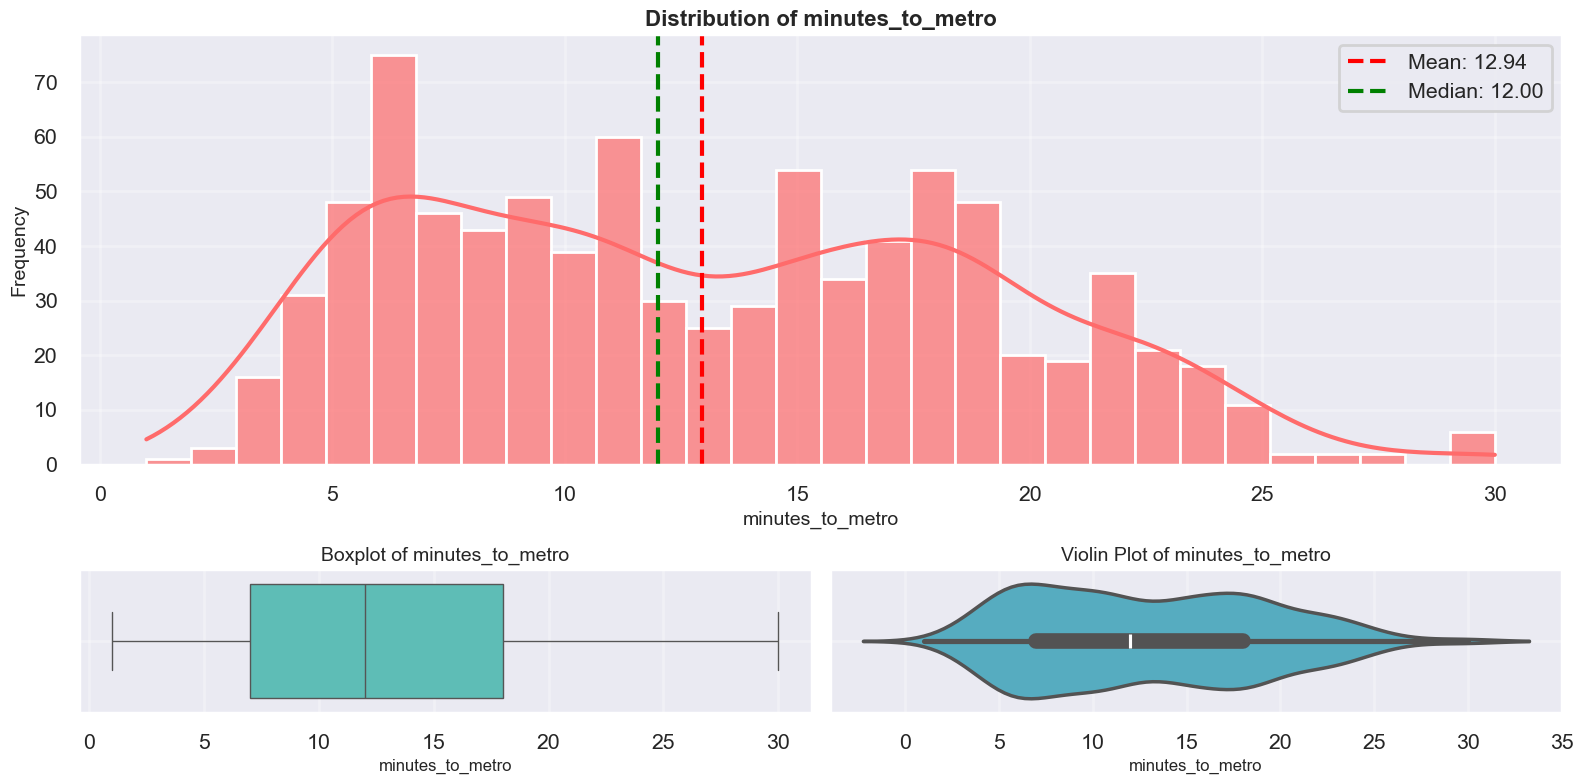

In [34]:
plot_numeric_col(df, 'minutes_to_metro')

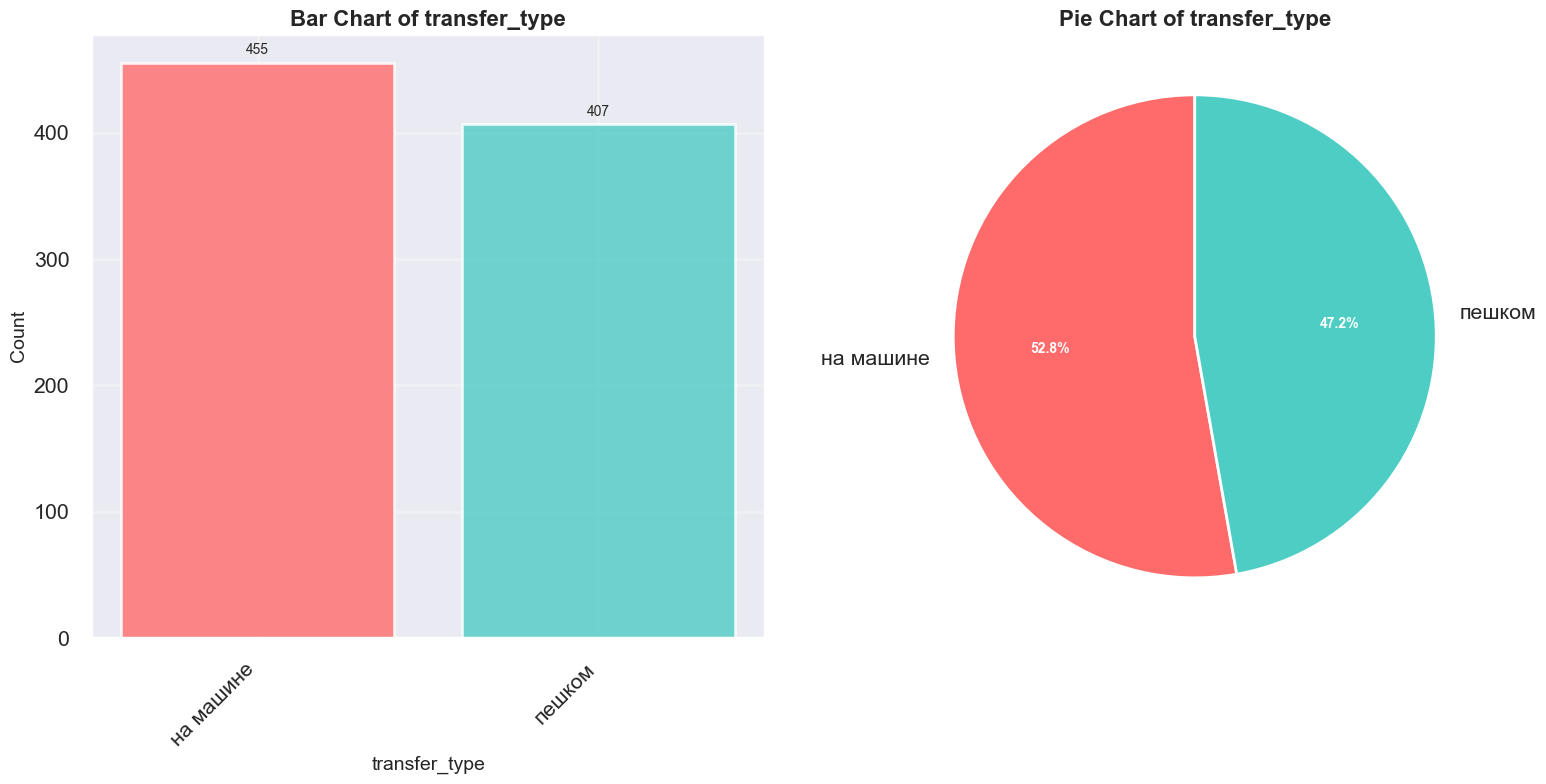

In [35]:
plot_categorical_col(df, 'transfer_type')

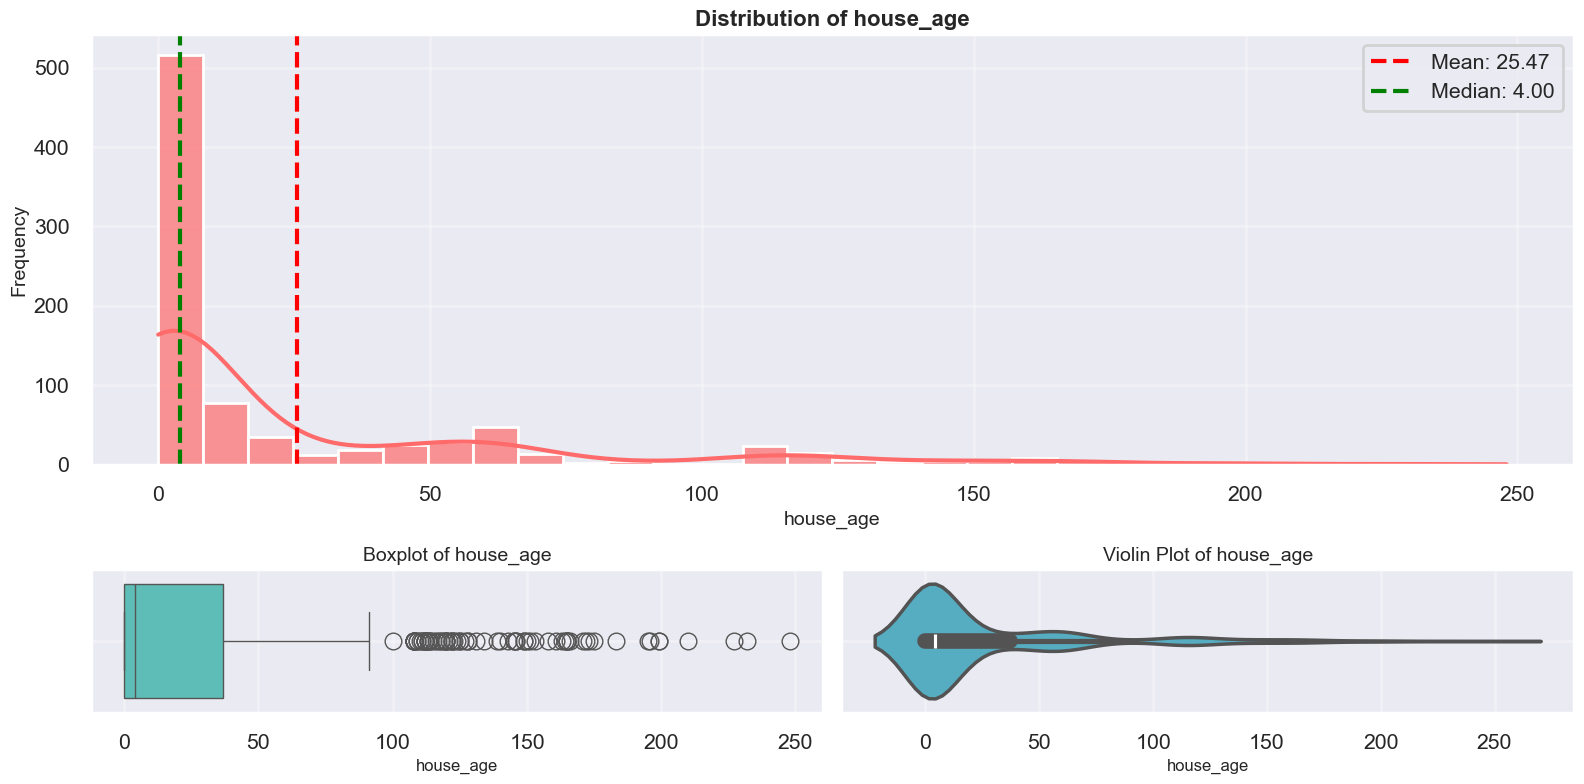

In [36]:
plot_numeric_col(df, 'house_age')

In [37]:
#df = df[df['house_age'] <= 180]

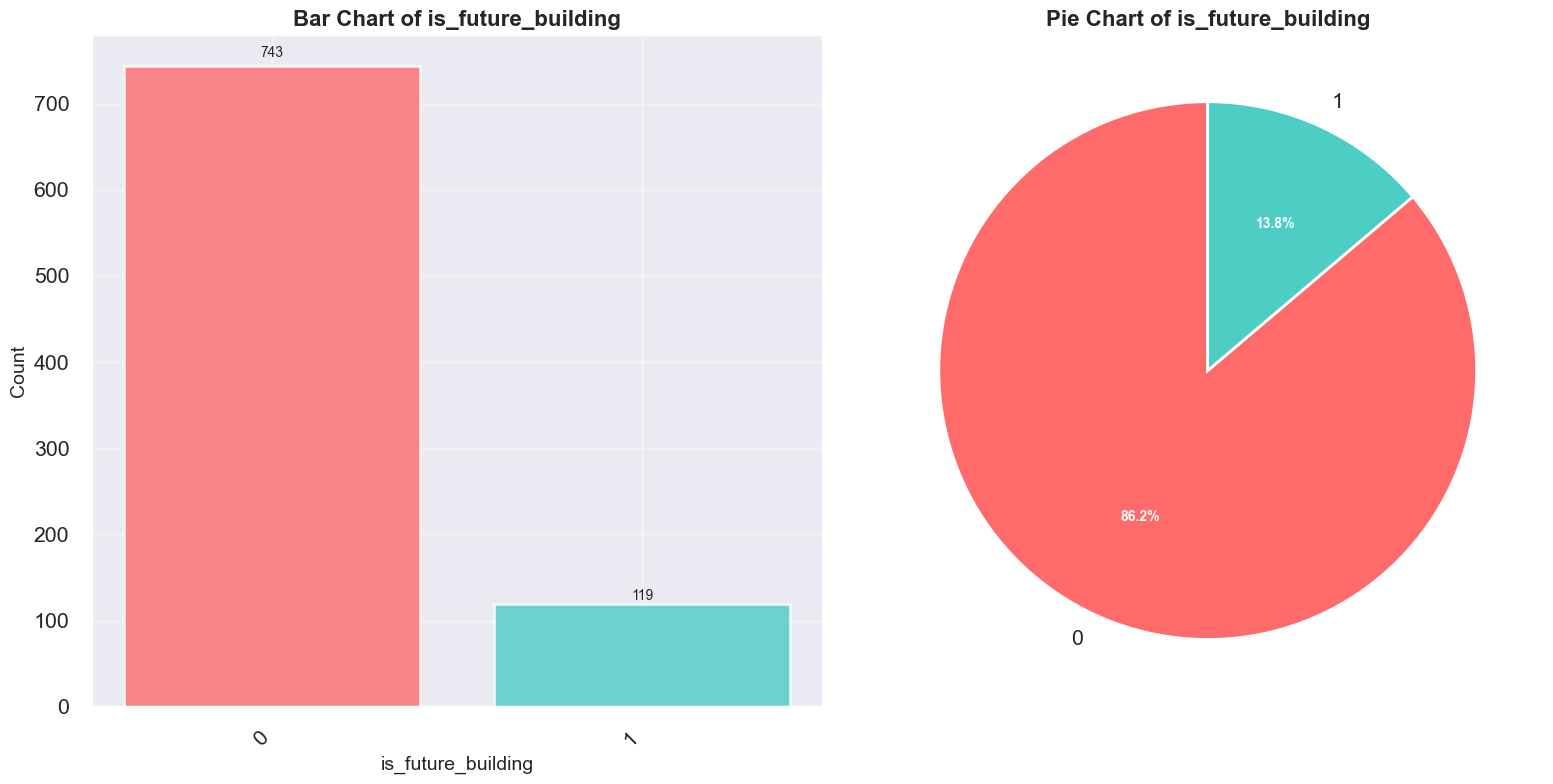

In [38]:
plot_categorical_col(df, 'is_future_building')

In [39]:
shape_after_eda = df.shape
diff = shape_before_eda[0] - shape_after_eda[0]
print(f'Всего удалено строк: {diff}, {diff/shape_before_eda[0]:.2%} % от исходного датасета')

Всего удалено строк: 136, 13.63% % от исходного датасета


## Корреляционный анализ

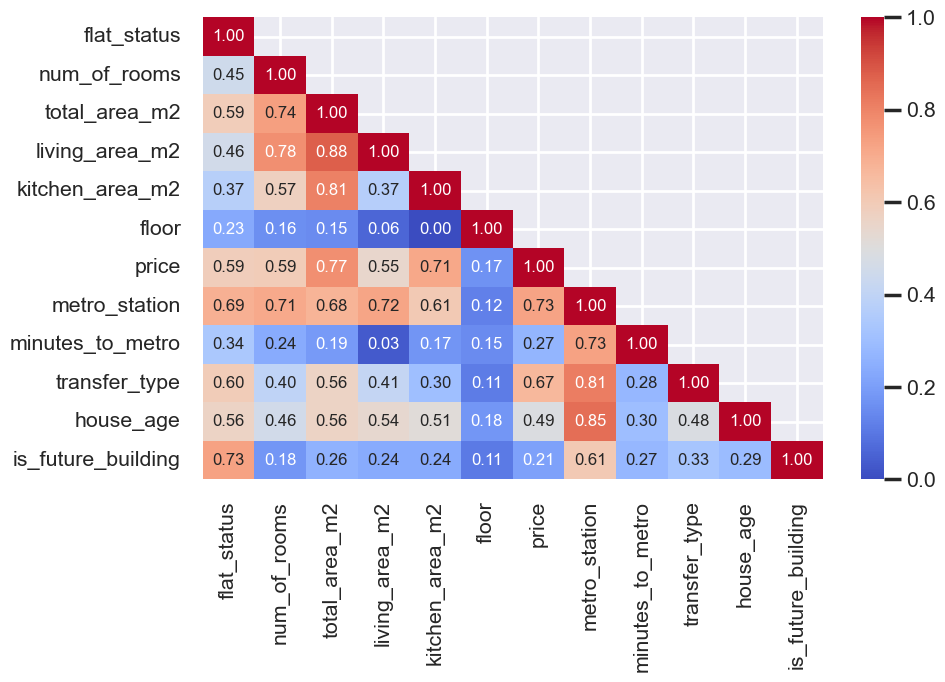

In [40]:
phik_mtx = phik_matrix(df, interval_cols=['flat_status',
                                            'total_area_m2',
                                            'living_area_m2',
                                            'kitchen_area_m2',
                                            'floor',
                                            'price',
                                            'minutes_to_metro',
                                            'house_age',
                                            'is_future_building'])
mask = np.triu(np.ones_like(phik_mtx, dtype=bool), k=1)
plt.figure(figsize=(10, 6))
sns.heatmap(phik_mtx, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1)
plt.show()


## Обучение моделей

In [41]:
df.head()

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
0,1,4-комнатная,125.50,75.8,22.9,4,24500000,Балтийская,5,на машине,149,0
1,1,2-комнатная,41.50,26.4,6.0,3,6300000,Московская,6,на машине,61,0
2,0,3-комнатная,80.39,44.9,10.2,3,30061520,Василеостровская,11,пешком,0,0
3,1,2-комнатная,65.10,27.0,19.0,4,11500000,Улица Дыбенко,7,на машине,42,0
4,1,1-комнатная,38.50,16.6,10.5,10,5599000,Девяткино,6,на машине,10,0


In [42]:
joblib.dump(df.metro_station.unique(), DATA_DIR / 'metro_station_names.joblib', compress=3)
joblib.dump(df.num_of_rooms.unique(), DATA_DIR / 'flat_type_names.joblib', compress=3)

['C:\\Users\\Mikhail\\Desktop\\coding\\notebooks\\my repositories\\Estate Saint-Petersburg\\data\\flat_type_names.joblib']

In [43]:
df.describe()

,flat_status,total_area_m2,living_area_m2,kitchen_area_m2,floor,price,minutes_to_metro,house_age,is_future_building
count,862.000000,862.000000,862.000000,862.000000,862.000000,8.620000e+02,862.000000,862.000000,862.000000
mean,0.650812,53.582320,27.369142,12.393387,5.738979,1.366733e+07,12.938515,25.470998,0.138051
std,0.476990,30.062348,19.178825,7.477801,4.664128,1.027147e+07,6.245997,43.077581,0.345154
min,0.000000,18.200000,6.300000,1.000000,1.000000,1.680000e+06,1.000000,0.000000,0.000000
25%,0.000000,32.270000,13.200000,6.700000,2.000000,5.807404e+06,7.000000,0.000000,0.000000
50%,1.000000,44.400000,21.000000,11.000000,4.000000,8.975000e+06,12.000000,4.000000,0.000000
75%,1.000000,70.075000,36.000000,16.075000,8.000000,1.980005e+07,18.000000,37.000000,0.000000
max,1.000000,234.000000,170.000000,61.000000,25.000000,4.490000e+07,30.000000,248.000000,1.000000


In [44]:
X = df.drop('price', axis=1)
y = df['price']

In [45]:
num_cols = ['total_area_m2',
            'living_area_m2',
            'kitchen_area_m2',
            'floor',
            'minutes_to_metro',
            'house_age']
cat_cols = ['flat_status',
            'num_of_rooms',
            'metro_station',
            'transfer_type',
            'is_future_building']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
X_train

,flat_status,num_of_rooms,total_area_m2,living_area_m2,kitchen_area_m2,floor,metro_station,minutes_to_metro,transfer_type,house_age,is_future_building
104,1,1-комнатная,31.23,14.1,10.1,7,Ленинский проспект,4,на машине,0,0
73,1,2-комнатная,75.90,51.7,19.2,9,Горный институт,10,пешком,5,0
153,1,1-комнатная,30.50,17.2,5.6,2,Академическая,12,пешком,60,0
356,0,2-комнатная,50.60,26.8,12.3,2,Чкаловская,18,пешком,0,1
727,1,1-комнатная,44.60,16.4,17.8,3,Удельная,9,пешком,4,0
...,...,...,...,...,...,...,...,...,...,...,...
409,1,Студия,22.00,11.0,6.0,12,Звездная,10,на машине,2,0
728,1,2-комнатная,70.10,28.1,19.8,10,Озерки,17,пешком,14,0
860,1,2-комнатная,70.20,35.7,13.2,6,Крестовский остров,21,пешком,3,0
376,0,Студия,20.56,10.0,5.0,8,Академическая,15,на машине,1,0


In [48]:
# Укажем юзера, который делает эксперименты
os.environ['USER'] = 'Mikhail Lodygin'

In [49]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5050")
mlflow.set_experiment("Estate Saint-Petersburg")

<Experiment: artifact_location=('file:///C:/Users/Mikhail/Desktop/coding/notebooks/my repositories/Estate '
 'Saint-Petersburg/mlflow/artefacts/824740557757289392'), creation_time=1756911751410, experiment_id='824740557757289392', last_update_time=1756911751410, lifecycle_stage='active', name='Estate Saint-Petersburg', tags={}>

In [50]:
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
     ('num', StandardScaler(), num_cols),
    ],
    remainder='passthrough'
)

In [51]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [52]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [1, 2, 3],
        'models__min_samples_split': [2, 3],
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [1, 2, 3],
        'models__min_samples_split': [2, 3],
    },
    {
        'models': [LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)]
    },
    {
        'models': [CatBoostRegressor(verbose=-1, random_state=RANDOM_STATE)]
    }
]

In [53]:
mlflow.sklearn.autolog()

In [54]:
gs = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

In [55]:
MLFLOW_RUN_NAME = "Test 3"
with mlflow.start_run(run_name=MLFLOW_RUN_NAME) as run:
    gs.fit(X_train, y_train)
    y_pred = gs.best_estimator_.predict(X_test)

    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_mae =  mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)

    print(f'Лучшая метрика при GridSearch: {-gs.best_score_:.2f}')
    print('*' * 50)
    print('Тест:')
    print(f'RMSE модели {test_rmse:.2f}')
    print(f'MAE модели {test_mae:.2f}')
    print(f'R2 модели {test_r2:.2f}')

2025/09/09 17:46:24 INFO mlflow.sklearn.utils: Logging the 5 best runs, 9 runs will be omitted.


🏃 View run unruly-sponge-343 at: http://localhost:5050/#/experiments/824740557757289392/runs/107ab3257fcc4332868361dc973b6188
🧪 View experiment at: http://localhost:5050/#/experiments/824740557757289392
🏃 View run worried-seal-306 at: http://localhost:5050/#/experiments/824740557757289392/runs/6b0097a2cf0c4da69498317016b35d00
🧪 View experiment at: http://localhost:5050/#/experiments/824740557757289392
🏃 View run able-fowl-130 at: http://localhost:5050/#/experiments/824740557757289392/runs/d8cb92bcc12f480fb515cce0ce8da0f3
🧪 View experiment at: http://localhost:5050/#/experiments/824740557757289392
🏃 View run overjoyed-mule-502 at: http://localhost:5050/#/experiments/824740557757289392/runs/ab63448a0d4946acba37d2f71dc03fa7
🧪 View experiment at: http://localhost:5050/#/experiments/824740557757289392
🏃 View run handsome-seal-50 at: http://localhost:5050/#/experiments/824740557757289392/runs/d8a849a301674538836e4995385b1bd2
🧪 View experiment at: http://localhost:5050/#/experiments/824740557

In [56]:
gs.best_estimator_

,steps,"[('preprocessor', ...), ('models', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
joblib.dump(gs.best_estimator_, DATA_DIR / 'pipeline.joblib', compress=3)

print("✅ Пайплайн сохранен!")
print("📁 Файл: pipeline.joblib")

✅ Пайплайн сохранен!
📁 Файл: real_estate_pipeline.joblib


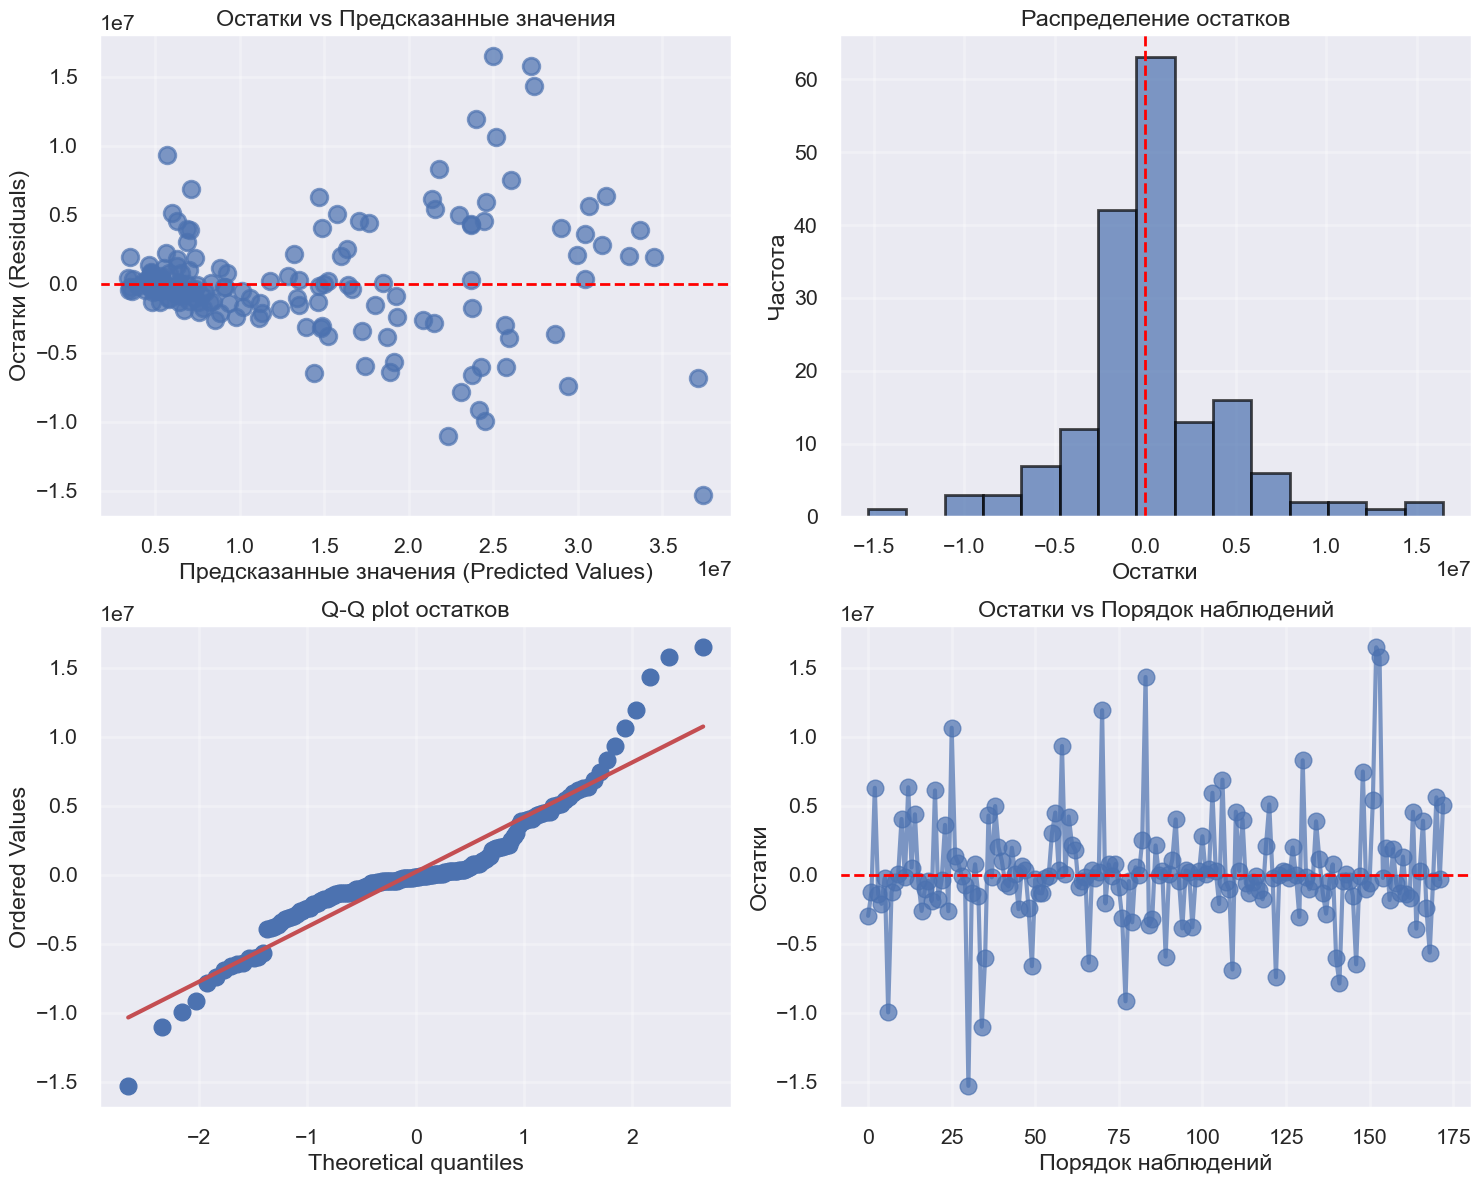

Статистика остатков:
Среднее остатков: 189782.0637
Стандартное отклонение: 4154252.6511
Медиана: -200006.4590
Минимальное значение: -15305127.7642
Максимальное значение: 16466776.6180


In [59]:
residuals = y_test - y_pred

# Создаем график
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Остатки vs Предсказанные значения (САМЫЙ ВАЖНЫЙ ГРАФИК)
axes[0, 0].scatter(y_pred, residuals, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Предсказанные значения (Predicted Values)')
axes[0, 0].set_ylabel('Остатки (Residuals)')
axes[0, 0].set_title('Остатки vs Предсказанные значения')
axes[0, 0].grid(True, alpha=0.3)

# 2. Распределение остатков (гистограмма)
axes[0, 1].hist(residuals, bins=15, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Остатки')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение остатков')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot для проверки нормальности распределения остатков
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q plot остатков')
axes[1, 0].grid(True, alpha=0.3)

# 4. Остатки vs Порядок наблюдений (для проверки автокорреляции)
axes[1, 1].plot(range(len(residuals)), residuals, 'o-', alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Порядок наблюдений')
axes[1, 1].set_ylabel('Остатки')
axes[1, 1].set_title('Остатки vs Порядок наблюдений')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("Статистика остатков:")
print(f"Среднее остатков: {np.mean(residuals):.4f}")
print(f"Стандартное отклонение: {np.std(residuals):.4f}")
print(f"Медиана: {np.median(residuals):.4f}")
print(f"Минимальное значение: {np.min(residuals):.4f}")
print(f"Максимальное значение: {np.max(residuals):.4f}")

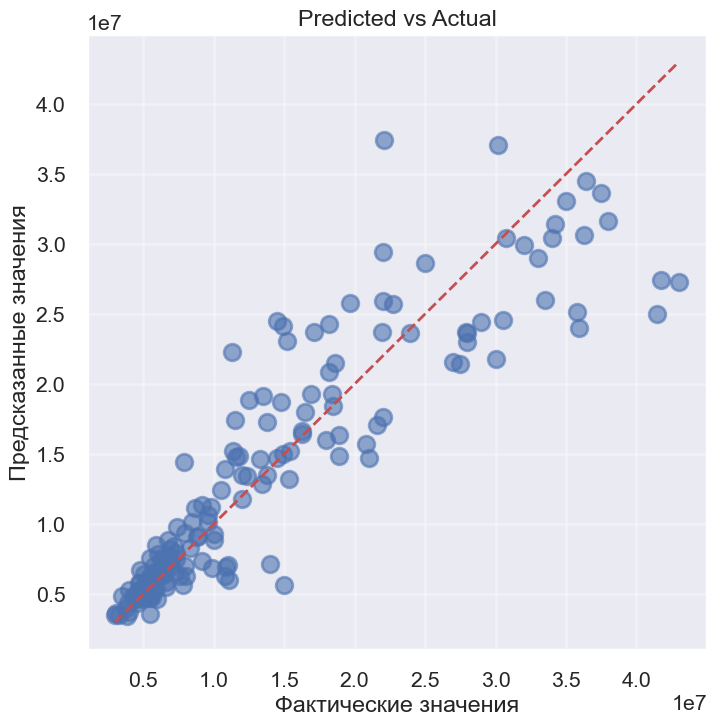

In [60]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # Идеальная линия y=x
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Predicted vs Actual')
plt.grid(True, alpha=0.3)
plt.show()

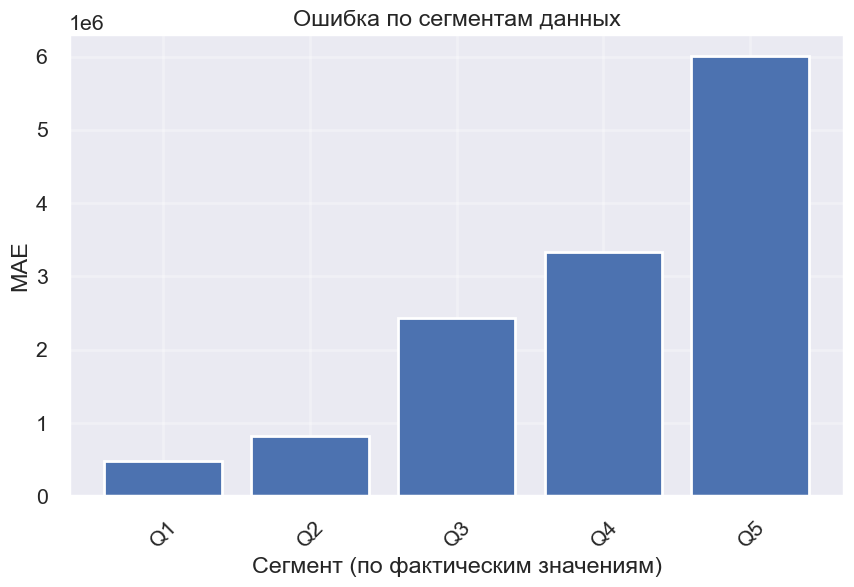

In [61]:
# Создаем сегменты по фактическим значениям
df_results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
df_results['segment'] = pd.qcut(df_results['actual'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Считаем MAE для каждого сегмента
segment_error = df_results.groupby('segment').apply(
    lambda x: mean_absolute_error(x['actual'], x['predicted'])
).reset_index(name='MAE')

plt.figure(figsize=(10, 6))
plt.bar(segment_error['segment'].astype(str), segment_error['MAE'])
plt.xlabel('Сегмент (по фактическим значениям)')
plt.ylabel('MAE')
plt.title('Ошибка по сегментам данных')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

In [62]:
gs.best_estimator_.named_steps['preprocessor'].transform(X_test).shape

(173, 79)

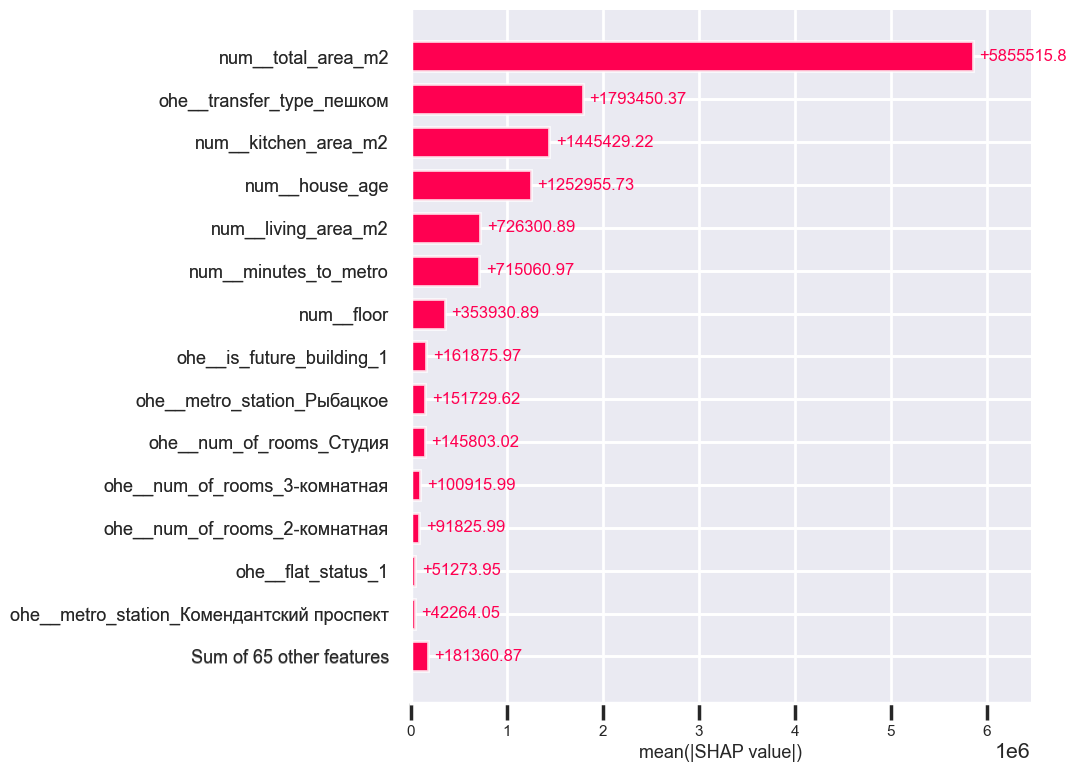

None

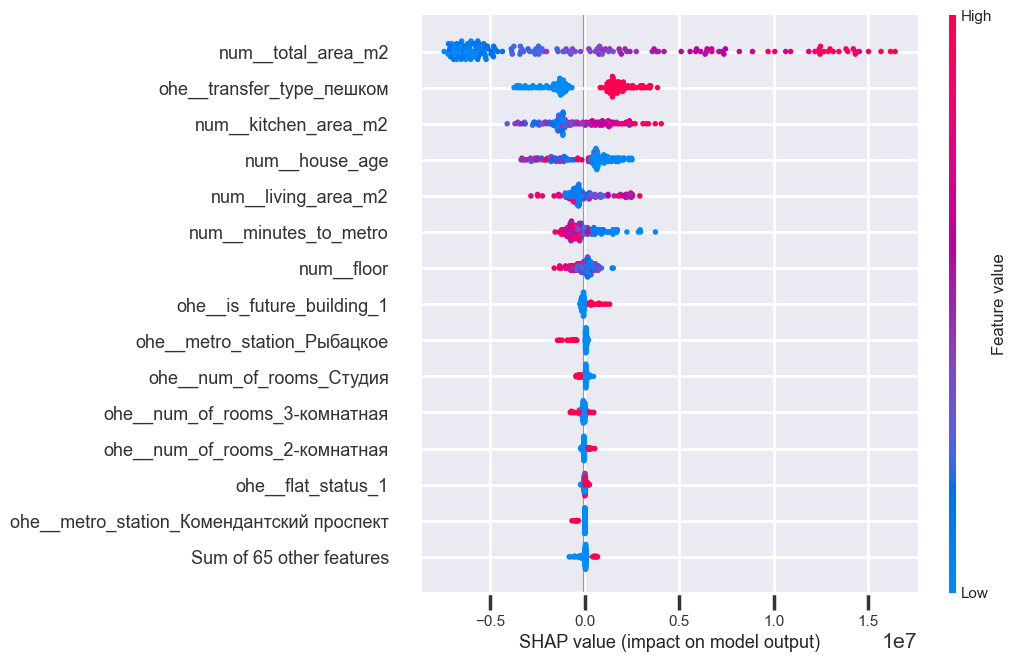

In [63]:
import shap

# Инициализируем explainer
explainer = shap.TreeExplainer(gs.best_estimator_.named_steps['models'])

X_test_2 = gs.best_estimator_.named_steps['preprocessor'].transform(X_test)
feature_names = gs.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)

display(shap.plots.bar(shap_values, max_display=15))
shap.plots.beeswarm(shap_values, max_display=15)